# Malmo Project Few-Shot Learning

Guide: https://huggingface.co/blog/setfit

Requires Python 3.7+

`pip install notebook seaborn pandas datasets setfit sentence-transformers torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116`

In [26]:
import pandas as pd
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer
import torch

In [27]:
# checking for gpu
torch.cuda.is_available()

True

In [28]:
# reading csv files train and test
label_names = {0: "Open chest", 
               1: "Break plant",
               2: "Go to animal",
               3: "Jump in water", 
               4: "Sit next to campfire",
               5: "Play music",
               6: "Go through fence",
               7: "Go inside door"}

dtypes = {"text": str, "label": "int8"}
train_df = pd.read_csv("train.csv", dtype=dtypes)
test_df = pd.read_csv("test.csv", dtype=dtypes)

sample = train_df.sample(5)
sample["task_name"] = sample["label"].map(label_names)
sample

,text,label,task_name
4,Use the chest,0,Open chest
41,Go to the campfire,4,Sit next to campfire
63,Step indoors,7,Go inside door
14,Go to that horse,2,Go to animal
56,Go into that gate,6,Go through fence


In [29]:
# loading pretrained model as guide
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")
model

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


SetFitModel()

In [30]:
# loading own dataset instead of the one in the guide
data_files = {"train": "train.csv", "test": "test.csv"}
dataset = load_dataset("csv", data_files=data_files)
dataset

Extracting data files: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.22it/s]


Dataset csv downloaded and prepared to C:/Users/shah_/.cache/huggingface/datasets/csv/default-e4ff0eea4401bc87/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 57.07it/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 64
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 26
    })
})

In [31]:
# building trainer as guide shows
trainer = SetFitTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    loss_class=CosineSimilarityLoss,
    batch_size=4,
    num_iterations=20, # Number of text pairs to generate for contrastive learning
    num_epochs=1 # Number of epochs to use for contrastive learning
)

In [32]:
# training and getting metrics as shows on guide(just accuracy, I guess)
trainer.train()
metrics = trainer.evaluate()
metrics

***** Running training *****
  Num examples = 2560
  Num epochs = 1
  Total optimization steps = 640
  Total train batch size = 4
Iteration:  10%|██████▉                                                               | 63/640 [00:09<01:25,  6.71it/s]


Iteration:  20%|█████████████▉                                                       | 129/640 [00:19<01:20,  6.31it/s]


Iteration:  30%|█████████████████████                                                | 195/640 [00:29<01:06,  6.71it/s]


Iteration:  41%|████████████████████████████▏                                        | 261/640 [00:39<00:56,  6.70it/s]


Iteration:  51%|███████████████████████████████████▎                                 | 327/640 [00:49<00:46,  6.77it/s]


Iteration:  61%|██████████████████████████████████████████▎                          | 393/640 [00:59<00:36,  6.81it/s]


Iteration:  72%|█████████████████████████████████████████████████▍                   | 459/640 [01:08<00:27,  6.64it/s]


Iteration:  82%|████████████████████████████████████████████████████████▌            | 525/640 [01:18<00:16,  6.84it/s]


Iteration:  92%|███████████████████████████████████████████████████████████████▋     | 591/640 [01:28<00:07,  6.79it/s]


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [01:35<00:00, 95.64s/it]
***** Running evaluation *****


{'accuracy': 0.9230769230769231}

In [33]:
# Test/New Instance Results
df = pd.read_csv("test.csv")
instances = df["text"].to_list()
df["pred"] = model(instances)
df["prob"] = torch.max(model.predict_proba(instances), axis=1).values
df

,text,label,pred,prob
0,Get me item from storage,0,0,0.932577
1,Open that storage and get me something,0,0,0.932750
2,Get me diamonds from that chest,0,0,0.913626
3,Get me an item from nature,1,0,0.433665
4,Break an item on grass,1,1,0.744274
5,Extract plant,1,1,0.932491
6,Go to horse,2,2,0.983922
7,Run towards that pig,2,2,0.983858
8,Arrive at the animal,2,2,0.983425
9,Go to,2,2,0.982249


Note how that last input text has very low confidence compared to the others

In [34]:
# Getting valid rows for evaluation / dropping -1 labels
df = df[df.label != -1]

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df["label"], df["pred"])

Accuracy: 1.0


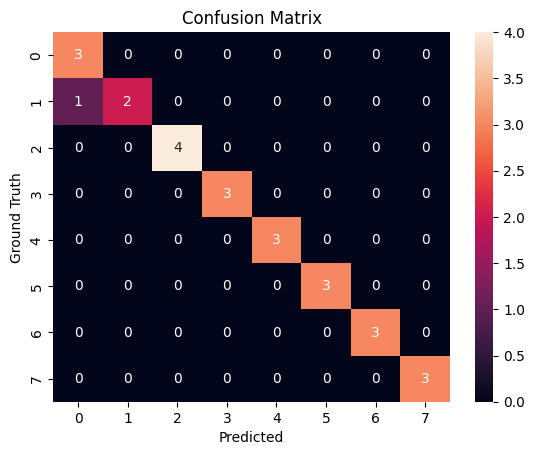

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

print(f"Accuracy: {len(df['label']==df['pred']) / len(df)}")
# Just plotting for easier read
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted');ax.set_ylabel('Ground Truth'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(label_names); ax.yaxis.set_ticklabels(label_names);

In [37]:
# Saving model
trainer.model.save_pretrained("malmoTextClassifier")